## Siamese Network for multi-view and multi-scale feature representation with Resnet as backbone for Thermogram classification
##### This notebook will demonstrate a novel multi-view and multi-scale feature representation network for classifying thermogram images

```
Author: Saqib Al Islam, University of Manitoba
```

 **Figure Representation of the network architecture**
 

---


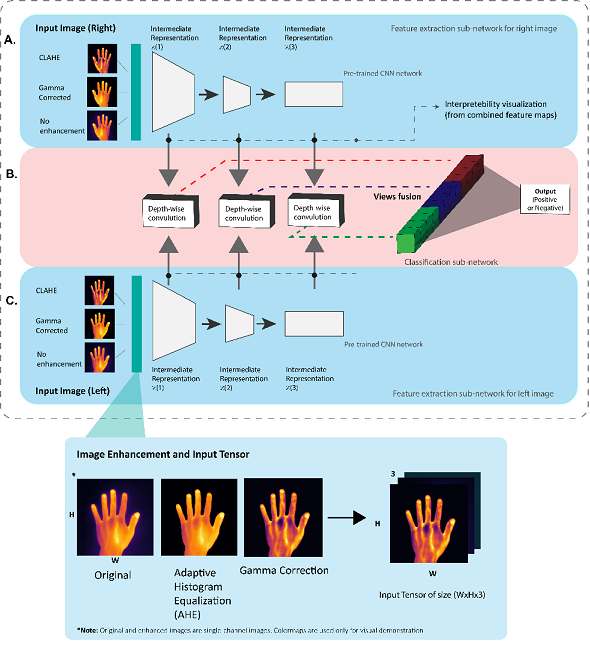

In [36]:
%env LD_LIBRARY_PATH='/home/saqib/anaconda3/envs/dlenv/lib'

env: LD_LIBRARY_PATH='/home/saqib/anaconda3/envs/dlenv/lib'


In [37]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from functools import partial

In [38]:
tf.__version__

'2.9.1'

In [39]:
# DL Imports
from numpy import concatenate
from keras.layers import Input, LeakyReLU, Add, UpSampling3D, Activation, SpatialDropout3D, Conv3D, Reshape, Dense, Flatten, Dropout, Subtract, BatchNormalization, GlobalAveragePooling2D
from keras.layers.core import Lambda
from keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import binary_crossentropy
from keras import backend as K
from keras import regularizers
# from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation, Add

from sklearn.metrics import log_loss
np.random.seed(1)

### Let us process the data first and prepare the **Data-Generators**

In [40]:
DATA_PATH = "/home/saqib/Plantar_Thermogram_Diabetes_Project/data/"
GENERAL_DATA_CSV = "/content/drive/MyDrive/UM_MSC/Research_Thermal_Imaging/data/ThermoDataBase/Plantar Thermogram Database.xlsx"
IMG_PATH = DATA_PATH + "CompressedData/"
TEST_PATH = DATA_PATH + "/test"
TEST_IMAGE_PATH = TEST_PATH + "/images"
ANNOT_PATH = TEST_PATH + "/annotation_results"
CSV_FILE_PATH = "/home/saqib/Plantar_Thermogram_Diabetes_Project/csvs/siamresnet/"
CHECKPOINT_FILE_PATH = DATA_PATH + "/checkpoints/"
UPDATE_FILE_PATH = DATA_PATH + "/updates/"

COMP_PATH = IMG_PATH 
ZIP_PATH = IMG_PATH + "CompressedData.zip"

In [41]:
path = Path(IMG_PATH)

In [42]:
cd $IMG_PATH

/home/saqib/Plantar_Thermogram_Diabetes_Project/data/CompressedData


## New data (Augmented)

In [43]:
def generateDataframes(Diab_R, Diab_L, Control_R, Control_L):
  Diab_R = pd.DataFrame.from_dict({"path":Diab_R, "labels":np.ones(len(Diab_R), dtype=np.int8)})
  Diab_L = pd.DataFrame.from_dict({"path":Diab_L, "labels":np.ones(len(Diab_L), dtype=np.int8)})
  Control_R = pd.DataFrame.from_dict({"path":Control_R, "labels":np.zeros(len(Control_R), dtype=np.int8)})
  Control_L = pd.DataFrame.from_dict({"path":Control_L, "labels":np.zeros(len(Control_L), dtype=np.int8)})

  Right = pd.concat([Diab_R, Control_R])
  Left = pd.concat([Diab_L, Control_L])

  PMT = np.random.permutation(len(Right))
  Right = Right.iloc[PMT]
  Left = Left.iloc[PMT]
  return (Right, Left)


AugmentedPath = ["/Augmented1","/Augmented2","Augmented3"]

DataPath = IMG_PATH + "Train" + AugmentedPath[0]
TrainDM_L = [DataPath + "/DM_L/" + s for s in sorted(os.listdir(DataPath + "/DM_L/"))]
TrainDM_R = [DataPath + "/DM_R/" + s for s in sorted(os.listdir(DataPath + "/DM_R/"))]
TrainCG_L = [DataPath  + "/CG_L/" + s for s in sorted(os.listdir(DataPath  + "/CG_L/"))]
TrainCG_R = [DataPath  + "/CG_R/" + s for s in sorted(os.listdir(DataPath  + "/CG_R/" ))]

DataPath = IMG_PATH + "Validation" + AugmentedPath[0]
ValDM_L = [DataPath + "/DM_L/" + s for s in sorted(os.listdir(DataPath + "/DM_L/"))]
ValDM_R = [DataPath + "/DM_R/" + s for s in sorted(os.listdir(DataPath + "/DM_R/"))]
ValCG_L = [DataPath  + "/CG_L/" + s for s in sorted(os.listdir(DataPath  + "/CG_L/"))]
ValCG_R = [DataPath  + "/CG_R/" + s for s in sorted(os.listdir(DataPath  + "/CG_R/" ))]

DataPath = IMG_PATH + "Test" + "/Corrected"
TestDM_L = [DataPath + "/DM_L/" + s for s in sorted(os.listdir(DataPath + "/DM_L/"))]
TestDM_R = [DataPath + "/DM_R/" + s for s in sorted(os.listdir(DataPath + "/DM_R/"))]
TestCG_L = [DataPath  + "/CG_L/" + s for s in sorted(os.listdir(DataPath  + "/CG_L/"))]
TestCG_R = [DataPath  + "/CG_R/" + s for s in sorted(os.listdir(DataPath  + "/CG_R/" ))]



TrainRight, TrainLeft = generateDataframes(TrainDM_R, TrainDM_L, TrainCG_R, TrainCG_L)
ValRight, ValLeft = generateDataframes(ValDM_R, ValDM_L, ValCG_R, ValCG_L)
TestRight, TestLeft = generateDataframes(TestDM_R, TestDM_L, TestCG_R, TestCG_L)

In [44]:
print(f"Train : DM {len(TrainDM_R)} CG {len(TrainCG_R)} Total {len(TrainDM_R) + len(TrainCG_R)} ")
print(f"Validation : DM {len(ValDM_R)} CG {len(ValCG_R)} Total {len(ValDM_R) + len(ValCG_R)}")
print(f"Test : DM {len(TestDM_R)} CG {len(TestCG_R)} Total {len(TestDM_R) + len(TestCG_R)}")
print(f"Total Pairs {len(TrainDM_R) + len(TrainCG_R) + len(ValDM_R) + len(ValCG_R) + len(TestDM_R) + len(TestCG_R)}")

Train : DM 1050 CG 1047 Total 2097 
Validation : DM 300 CG 300 Total 600
Test : DM 13 CG 6 Total 19
Total Pairs 2716


##### Image enhancement functions

In [45]:
import scipy as sp
import cv2 as cv
import sys
from PIL import Image
print(Image.__file__)
sys.modules['Image'] = Image 

def adjust_gamma(image, gamma=0.6):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
  # img = PIL.Image.fromarray(image).convert('RGB') 
  img = cv.cvtColor(np.float32(np.array(image)), cv.COLOR_BGR2GRAY)
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
  return cv.LUT(image, table)
 
def adjust_clahe(image):
  # img = PIL.Image.fromarray(image).convert('RGB') 
  img = cv.cvtColor(np.array(image), cv.COLOR_BGR2GRAY)
  #img[img < 90] = 0
  # create a CLAHE object (Arguments are optional).
  clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
  im = clahe.apply(img)
  # imC = cv.applyColorMap(im, cv.COLORMAP_INFERNO)
  return im

/home/saqib/anaconda3/envs/dlenv/lib/python3.10/site-packages/PIL/Image.py


### Custom Data Generator for input [Right image, Left image] output: [Class]

In [46]:
ENHANCEMENT_TYPE = dict({"Clahe":"clahe", "Gamma":"gamma", "None":"none","All":"all"})

class CustomLRDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df0 , df1, X_col = {"path":"path"}, y_col = { "label":"labels" },
                 batch_size = 32,
                 input_size=(128, 128),
                 num_classes = 2,
                 image_enhancement=ENHANCEMENT_TYPE["None"],
                 shuffle=True):
        
        self.df0 = df0.copy()
        self.df1 = df1.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.labels = df0["labels"].values
        self.image_enhancement=image_enhancement
        self.n = len(self.df1) # Size of data available. Since left and right images in same number we can take either

    def __getitem__(self, index):
    
      batches0 = self.df0[index * self.batch_size:(index + 1) * self.batch_size]
      batches1 = self.df1[index * self.batch_size:(index + 1) * self.batch_size]
      X, y = self.__get_data(batches0, batches1)        
      return X, y

    def __get_data(self, batches0, batches1):
      # Generates data containing batch_size samples

      input0_batch = batches0[self.X_col['path']] # Load batch of paths for right images
      input1_batch = batches1[self.X_col['path']] # Load batch of paths for left images
      label_batch = batches0[self.y_col['label']] # Both left and right image class will be same
      

      X_batch0 = np.asarray([self.__get_input(x, self.input_size) for x in input0_batch])
      X_batch1 = np.asarray([self.__get_input(x, self.input_size) for x in input1_batch])
      y_batch = ([y for y in label_batch])


      return tuple([X_batch0, X_batch1]), y_batch
    
    def __get_input(self, path, target_size):
        image0 = tf.keras.preprocessing.image.load_img(path).convert("RGB")

        if(self.image_enhancement == ENHANCEMENT_TYPE["Clahe"]):
          # DO CLAHE Enhancement
          image0 = adjust_clahe(image0)
          img2 = np.zeros( ( np.array(image0).shape[0], np.array(image0).shape[1], 3 ) )
          img2[:,:,0] = image0 # same value in each channel
          img2[:,:,1] = image0
          img2[:,:,2] = image0
          image0 = img2

        elif(self.image_enhancement == ENHANCEMENT_TYPE["Gamma"]):
          # DO Gamma Enhancement
          image0 = np.array(image0).astype("uint8")
          image0 = adjust_gamma(image0)
        

        elif(self.image_enhancement == ENHANCEMENT_TYPE["None"]):
          # DO Gamma Enhancement
          image0 = image0
        elif(self.image_enhancement == ENHANCEMENT_TYPE["All"]):
          # DO Gamma Enhancement
          clahe = adjust_clahe(image0)
          gamma = np.array(image0).astype("uint8")
          img2 = np.zeros( ( np.array(image0).shape[0], np.array(image0).shape[1], 3 ) )
          img2[:,:,0] = clahe # same value in each channel
          img2[:,:,1] = gamma[:,:,0]
          img2[:,:,2] = np.array(image0)[:,:,0]
          image0 = img2
        

        image0_arr = tf.keras.preprocessing.image.img_to_array(image0)
        # Return normalized images
        return image0_arr

    def on_epoch_end(self):
        if self.shuffle:
            self.df0 = self.df0.sample(frac=1).reset_index(drop=True)
            self.df1 = self.df1.sample(frac=1).reset_index(drop=True)
        
    def __get_output(self, label, num_classes):
      return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __len__(self):
        return self.n // self.batch_size

### Custom Data loader with images concatenated
- Input (x1, x2) Output (x1x2)

In [52]:

class CustomLRDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df0 , df1, X_col = {"path":"path"}, y_col = { "label":"labels" },
                 batch_size = 32,
                 input_size=(128, 128),
                 num_classes = 2,
                 image_enhancement=ENHANCEMENT_TYPE["None"],
                 shuffle=True):
        
        self.df0 = df0.copy()
        self.df1 = df1.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.labels = df0["labels"].values
        self.image_enhancement=image_enhancement
        self.n = len(self.df1) # Size of data available. Since left and right images in same number we can take either

    def __getitem__(self, index):
    
      batches0 = self.df0[index * self.batch_size:(index + 1) * self.batch_size]
      batches1 = self.df1[index * self.batch_size:(index + 1) * self.batch_size]
      X, y = self.__get_data(batches0, batches1)        
      return X, y

    def __get_data(self, batches0, batches1):
      # Generates data containing batch_size samples

      input0_batch = batches0[self.X_col['path']] # Load batch of paths for right images
      input1_batch = batches1[self.X_col['path']] # Load batch of paths for left images
      label_batch = batches0[self.y_col['label']] # Both left and right image class will be same
      

      X_batch0 = np.asarray([self.__get_input(x, self.input_size) for x in input0_batch])
      X_batch1 = np.asarray([self.__get_input(x, self.input_size) for x in input1_batch])
      y_batch = ([y for y in label_batch])


      return tuple([X_batch0, X_batch1]), y_batch
    
    def __get_input(self, path, target_size):
        image0 = tf.keras.preprocessing.image.load_img(path).convert("RGB")

        if(self.image_enhancement == ENHANCEMENT_TYPE["Clahe"]):
          # DO CLAHE Enhancement
          image0 = adjust_clahe(image0)
          img2 = np.zeros( ( np.array(image0).shape[0], np.array(image0).shape[1], 3 ) )
          img2[:,:,0] = image0 # same value in each channel
          img2[:,:,1] = image0
          img2[:,:,2] = image0
          image0 = img2

        elif(self.image_enhancement == ENHANCEMENT_TYPE["Gamma"]):
          # DO Gamma Enhancement
          image0 = np.array(image0).astype("uint8")
          image0 = adjust_gamma(image0)
        

        elif(self.image_enhancement == ENHANCEMENT_TYPE["None"]):
          # DO Gamma Enhancement
          image0 = image0
        elif(self.image_enhancement == ENHANCEMENT_TYPE["All"]):
          # DO Gamma Enhancement
          clahe = adjust_clahe(image0)
          gamma = np.array(image0).astype("uint8")
          img2 = np.zeros( ( np.array(image0).shape[0], np.array(image0).shape[1], 3 ) )
          img2[:,:,0] = clahe # same value in each channel
          img2[:,:,1] = gamma[:,:,0]
          img2[:,:,2] = np.array(image0)[:,:,0]
          image0 = img2
        

        image0_arr = tf.keras.preprocessing.image.img_to_array(image0)
        # Return normalized images
        return image0_arr/255.0

    def on_epoch_end(self):
        if self.shuffle:
            self.df0 = self.df0.sample(frac=1).reset_index(drop=True)
            self.df1 = self.df1.sample(frac=1).reset_index(drop=True)
        
    def __get_output(self, label, num_classes):
      return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __len__(self):
        return self.n // self.batch_size

(-0.5, 127.5, 127.5, -0.5)

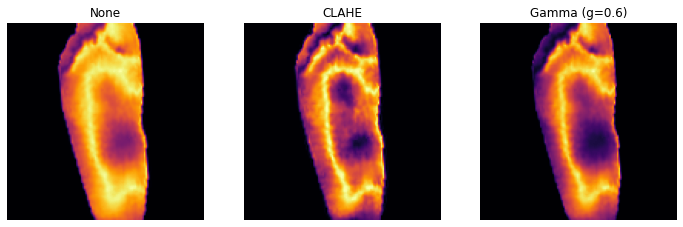

In [53]:

plt.rcParams["figure.figsize"] = (12,6)

traingen = CustomLRDataGen(TrainRight,TrainLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["None"])
valgen = CustomLRDataGen(ValRight,ValLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["None"])
testgen = CustomLRDataGen(TestRight,TestLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["None"])
itr = traingen.__iter__()
val_itr = valgen.__iter__()
test_itr = testgen.__iter__()
X, y= next(itr)

sample_img = X[0][0]
plt.subplot(1,3,1)
plt.imshow(sample_img[:,:,0], cmap="inferno")
plt.title("None")
plt.axis(False)
plt.subplot(1,3,2)
plt.imshow(adjust_clahe((sample_img * 255).astype("uint8")), cmap="inferno")
plt.title("CLAHE")
plt.axis(False)
plt.subplot(1,3,3)
plt.title("Gamma (g=0.6)")
plt.imshow(adjust_gamma((sample_img * 255).astype("uint8"), gamma=0.5)[:,:,0], cmap="inferno")
plt.axis(False)


[0, 0, 1, 0, 0, 1, 1, 0]
[1, 0, 0, 0, 0, 1, 0, 1]


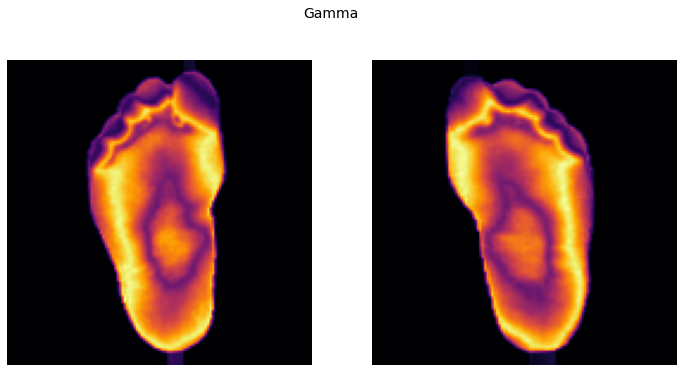

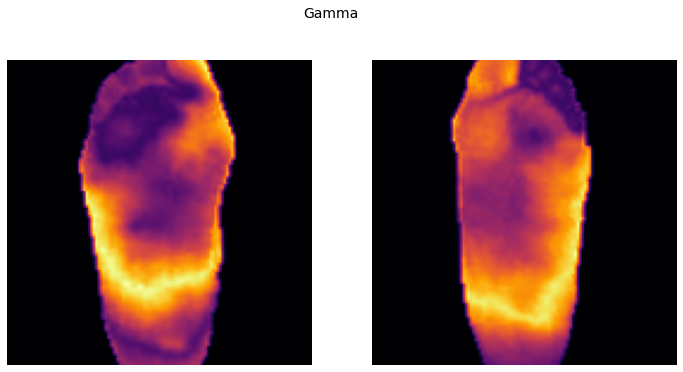

In [54]:
# Sanity check to test generator outputs
for i in range(0,2):
  X, y= next(itr)
  print(y)
  plt.figure()
  plt.suptitle("Gamma",fontsize=14)
  plt.subplot(1,2,1)
  plt.grid(False)
  plt.axis(False)
  plt.imshow(X[0][0][:,:,0], cmap="inferno")
  plt.subplot(1,2,2)
  plt.grid(False)
  plt.axis(False)
  plt.imshow(X[1][0][:,:,0], cmap="inferno")

###### Install keras-contrib package

In [55]:
!pip install git+https://www.github.com/farizrahman4u/keras-contrib.git

  Cloning https://www.github.com/farizrahman4u/keras-contrib.git to /tmp/pip-req-build-c9yhu9ax
  Running command git clone -q https://www.github.com/farizrahman4u/keras-contrib.git /tmp/pip-req-build-c9yhu9ax
  Resolved https://www.github.com/farizrahman4u/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0


In [56]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False, kernel=(3, 3), activation=None,
                             padding='same', strides=(1, 1), instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv2D(n_filters, kernel, padding=padding, strides=strides)(input_layer)
    if batch_normalization:
        layer = BatchNormalization(axis=1)(layer)
    elif instance_normalization:
        try:
            from keras_contrib.layers.normalization import InstanceNormalization
            from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
        except ImportError:
            raise ImportError("Install keras_contrib in order to use instance normalization."
                              "\nTry: pip install git+https://www.github.com/farizrahman4u/keras-contrib.git")
        layer = InstanceNormalization(axis=1)(layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)


In [57]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(128,128,3),
                                                include_top=False,
                                                weights='imagenet')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [58]:
def pre_resnet50(inputs,IMG_SHAPE,mask_name):
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

 
  #x = data_augmentation(inputs)
  base_model.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  
  # Use the activations of these layers
  layer_names = [
      'conv1_relu',   # 64x64
      'conv2_block3_2_relu',   # 32x32
      'conv3_block4_2_relu',   # 16x16
      'conv4_block3_2_relu',  # 8x8
  ]
  return_layers = [base_model.get_layer(name).output for name in layer_names]

    

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=return_layers)


  # mobilemodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy',tf.keras.metrics.AUC()])

  return down_stack, return_layers

In [59]:
    
from keras import backend as K

def loss_(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred)

## F1 Score keras  Source: https://datascience.stackexchange.com/a/45166 
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


#### SiamResnet model

In [60]:
def siam2dresnet_model(input_shape=(128, 128, 3), optimizer=Adam, initial_learning_rate=0.000025, activation_name="sigmoid",plot_model=True, **kwargs):
    inputs_1 = Input(shape=input_shape)
    inputs_2 = Input(shape=input_shape)
    
    preprocess_input = tf.keras.applications.resnet50.preprocess_input


    #input_m_shape = tuple([1] + list(input_shape[1:]))
    #inputs_m1 = Input(input_m_shape)
    #inputs_m2 = Input(input_m_shape)

    downstack1, _ = pre_resnet50(inputs_1, input_shape, mask_name='mask1')
    downstack2, _ = pre_resnet50(inputs_2, input_shape, mask_name='mask2')

    return_layers_1 = downstack1(preprocess_input(inputs_1))
    return_layers_2 = downstack2(preprocess_input(inputs_2))
    
    print(return_layers_1)
    print(return_layers_2)
   
    # _, return_layers_1 = MobileNetV2(inputs_1,1, mask_name='mask1')
    # _, return_layers_2 = MobileNetV2(inputs_2,1, mask_name='mask2')

    sf1_0 = return_layers_1[0] #sf:select feature
    sf2_0 = return_layers_2[0]
    #sf1_0 = BatchNormalization(axis=1)(sf1_0)
    #sf2_0 = BatchNormalization(axis=1)(sf2_0)
    #sf_0 = sf_module(sf1_0, sf2_0, 64)
    #sf_0 = sf_module(sf1_0, sf2_0, 1)
    #sf_0 = Add()([sf1_0, sf2_0]
    sf_0 = Subtract()([sf1_0, sf2_0])
    #sf_0 = concatenate([sf1_0, sf2_0], axis=1)
    sf_0 = create_convolution_block(sf_0, 32)


    #out_sf = Conv3D(1, (36, 36, 36), kernel_initializer=kernel_init(sf1_1))(sf2_1)

    sf1_1 = return_layers_1[1]
    sf2_1 = return_layers_2[1]
    #sf1_1 = InstanceNormalization(axis=1)(sf1_1)
    #sf2_1 = InstanceNormalization(axis=1)(sf2_1)
    #sf_1 = sf_module(sf1_1, sf2_1, 256)
    #sf_1 = sf_module(sf1_1, sf2_1, 1)
    #sf_1 = Add()([sf1_1, sf2_1])
    sf_1 = Subtract()([sf1_1, sf2_1])
    sf_1 = create_convolution_block(sf_1, 32)


    sf1_2 = return_layers_1[2] 
    sf2_2 = return_layers_2[2]
    #sf_2 = sf_module(sf1_2, sf2_2, 3)
    #sf_2 = sf_module(sf1_2, sf2_2, 1)
    sf_2 = Subtract()([sf1_2, sf2_2])
    sf_2 = create_convolution_block(sf_2, 32)

    sf1_3 = return_layers_1[3] 
    sf2_3 = return_layers_2[3]
    #sf_2 = sf_module(sf1_2, sf2_2, 3)
    #sf_2 = sf_module(sf1_2, sf2_2, 1)
    sf_3 = Subtract()([sf1_3, sf2_3])
    sf_3 = create_convolution_block(sf_3, 32)


    # out_pred_mask_1 = return_layers_1[-1]
    # out_pred_mask_2 = return_layers_2[-1]

    sf_0 = GlobalAveragePooling2D()(sf_0)
    sf_1 = GlobalAveragePooling2D()(sf_1)
    sf_2 = GlobalAveragePooling2D()(sf_2)
    sf_3 = GlobalAveragePooling2D()(sf_3)
    

    sf_add = Add()([sf_0, sf_1, sf_2,sf_3])
    #sf_add = concatenate([sf_0, sf_1, sf_2], axis=1)

    #sf_0 = GlobalAveragePooling3D()(sf_0)
    #sf_1 = GlobalAveragePooling3D()(sf_1)



    #sf_0 = Lambda(print_output, arguments={'msg':' sf_0'})(sf_0)
    #sf_1 = Lambda(print_output, arguments={'msg':' sf_1'})(sf_1)

    #sf_0_max = Lambda(print_output_max, arguments={'msg':' sf_0_max'})(sf_0)
    #sf_1_max = Lambda(print_output_max, arguments={'msg':' sf_1_max'})(sf_1)


    #sf_add = concatenate([sf_0, sf_1], axis=1)
    #sf_add = Lambda(print_output, arguments={'msg':' sf_add'})(sf_add)

    #out_m1 = GlobalAveragePooling3D()(out_pred_mask_1)

    #sf_add = GlobalAveragePooling3D()(sf1_1)


    #out_pred_score = Activation(activation_name)(sf_add)

    #for i in range(len(out_pred_score.shape)-1):
    #    out_pred_score = K.squeeze(out_pred_score, axis=-1)

    #out_pred_score = Reshape(target_shape=())(out_pred_score)

    sf_add = Flatten()(sf_add)



    # out_pred_score = Dense(1, activation=activation_name, name='score')(sf_add)
    # out_pred_score = Dense(1, activation=activation_name)(sf_add)

    #sf_add = Dense(10, activation='relu', kernel_initializer='Ones')(sf_add)
    #sf_add = Dense(10, activation='relu')(sf_add)
    #sf_add = Lambda(print_output, arguments={'msg':' sf_add'})(sf_add)

    sf_add = Dropout(0.2)(sf_add)

    #out_pred_score = Dense(1, activation=None, kernel_initializer='Ones')(sf_add)
    #out_pred_score = Dense(1, activation=None, kernel_regularizer=regularizers.l2(0.01))(sf_add)
    out_pred_score = Dense(512, activation=None, kernel_regularizer=regularizers.l2(0.2))(sf_add)
    out_pred_score = Dense(256, activation=None, kernel_regularizer=regularizers.l2(0.05))(out_pred_score)
    out_pred_score = Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.01))(out_pred_score)
    out_pred_score = Dense(1)(out_pred_score)
    
    #out_pred_score = Lambda(print_output, arguments={'msg':' output'})(out_pred_score)
    out_pred_score = Activation(activation_name, name='score')(out_pred_score)
    #out_pred_score = Lambda(print_output, arguments={'msg':' output sigmoid'}, name='score')(out_pred_score)


    #tf.print(out_pred_score)
    #print_layer = Lambda((lambda x: tf.Print(x, [x], 'out_pred_score= ')), name='print')(out_pred_score)
    #print_layer = Lambda((lambda x: tf.Print(x, [x], message='out_pred_score= ', first_n=-1, summarize=1024)), name='print')(out_pred_score)


    model = Model(inputs=[inputs_1, inputs_2], outputs=[out_pred_score])

    #parallel_model = multi_gpu_model(model, gpus=2)
    # Learning Rate exponential decay
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    # initial_learning_rate,
    # decay_steps=100000,
    # decay_rate=0.96,
    # staircase=False)

    model.compile(optimizer=Adam(learning_rate=initial_learning_rate), 
                  loss={'score':tf.keras.losses.BinaryCrossentropy(from_logits=False)}, 
                  metrics={'score': [tf.keras.metrics.AUC(),f1_m,"accuracy"]})
    #model.compile(optimizer=optimizer(lr=initial_learning_rate), loss={'score':'binary_crossentropy'}, metrics=['accuracy'])
    if plot_model:
        tf.keras.utils.plot_model(model, to_file=f'{CSV_FILE_PATH}model.png', show_shapes=True)

    #model.metrics_tensors += model.outputs
    return model


In [61]:
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import math 
import datetime

name = "pre-resnet50-none-4"

# learning rate schedule
def step_decay(epoch, initial_lrate, drop, epochs_drop):
    return initial_lrate * math.pow(drop, math.floor((1+epoch)/float(epochs_drop)))

# Callbacks while training
def get_callbacks(model_file, initial_learning_rate=0.005, learning_rate_drop=0.3, learning_rate_epochs=None,
                  learning_rate_patience=50, logging_file=f"{CSV_FILE_PATH}{name}-training.log", verbosity=1,
                  early_stopping_patience=None):
    callbacks = list()
    callbacks.append(ModelCheckpoint(filepath=CSV_FILE_PATH + name +'.{epoch:02d}-{val_accuracy:.2f}.h5',save_best_only=True, mode="max", monitor='val_accuracy'))
    callbacks.append(CSVLogger(logging_file, append=True))
    log_dir = CSV_FILE_PATH + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # callbacks.append(tensorboard_callback)

    # Create a callback that saves the model's weights every 5 epochs
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #   filepath=CHECKPOINT_FILE_PATH+"/atten-cp-{epoch:04d}.ckpt", 
    #   verbose=0, 
    #   save_weights_only=True,
    #   save_freq=10)
    #callbacks.append(cp_callback)

    if learning_rate_epochs:
        callbacks.append(LearningRateScheduler(partial(step_decay, initial_lrate=initial_learning_rate,
                                                       drop=learning_rate_drop, epochs_drop=learning_rate_epochs)))
    else:
        callbacks.append(ReduceLROnPlateau(factor=learning_rate_drop, patience=learning_rate_patience,
                                           verbose=verbosity))
    if early_stopping_patience:
        callbacks.append(EarlyStopping(monitor="val_accuracy", verbose=verbosity, patience=early_stopping_patience, min_delta=0.1))
    return callbacks
  
def train_model(model, model_file, training_generator, validation_generator, steps_per_epoch, validation_steps,
                initial_learning_rate=0.005, learning_rate_drop=0.5, learning_rate_epochs=None, n_epochs=85,
                learning_rate_patience=20, early_stopping_patience=None):
    """
    Train a Keras model.
    :param early_stopping_patience: If set, training will end early if the validation loss does not improve after the
    specified number of epochs.
    :param learning_rate_patience: If learning_rate_epochs is not set, the learning rate will decrease if the validation
    loss does not improve after the specified number of epochs. (default is 20)
    :param model: Keras model that will be trained.
    :param model_file: Where to save the Keras model.
    :param training_generator: Generator that iterates through the training data.
    :param validation_generator: Generator that iterates through the validation data.
    :param steps_per_epoch: Number of batches that the training generator will provide during a given epoch.
    :param validation_steps: Number of batches that the validation generator will provide during a given epoch.
    :param initial_learning_rate: Learning rate at the beginning of training.
    :param learning_rate_drop: How much at which to the learning rate will decay.
    :param learning_rate_epochs: Number of epochs after which the learning rate will drop.
    :param n_epochs: Total number of epochs to train the model.
    :return: 
    """

    history = model.fit_generator(generator=training_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=n_epochs, verbose=1,
                        validation_data=validation_generator,
                        validation_steps=validation_steps,
                        callbacks=get_callbacks(model_file,
                                              initial_learning_rate=initial_learning_rate,
                                              learning_rate_drop=learning_rate_drop,
                                              learning_rate_epochs=learning_rate_epochs,
                                              learning_rate_patience=learning_rate_patience,
                                              early_stopping_patience=early_stopping_patience))
    
    pd.DataFrame(history.history).to_csv(f"{CSV_FILE_PATH}{name}-history.csv")
    return history

In [62]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
model = siam2dresnet_model(initial_learning_rate=0.00000025)
#model.load_weights(f"{CSV_FILE_PATH}/model5000.08-1.06.h5")

[<tf.Tensor 'model_6/conv1_relu/Relu:0' shape=(None, 64, 64, 64) dtype=float32>, <tf.Tensor 'model_6/conv2_block3_2_relu/Relu:0' shape=(None, 32, 32, 64) dtype=float32>, <tf.Tensor 'model_6/conv3_block4_2_relu/Relu:0' shape=(None, 16, 16, 128) dtype=float32>, <tf.Tensor 'model_6/conv4_block3_2_relu/Relu:0' shape=(None, 8, 8, 256) dtype=float32>]
[<tf.Tensor 'model_7/conv1_relu/Relu:0' shape=(None, 64, 64, 64) dtype=float32>, <tf.Tensor 'model_7/conv2_block3_2_relu/Relu:0' shape=(None, 32, 32, 64) dtype=float32>, <tf.Tensor 'model_7/conv3_block4_2_relu/Relu:0' shape=(None, 16, 16, 128) dtype=float32>, <tf.Tensor 'model_7/conv4_block3_2_relu/Relu:0' shape=(None, 8, 8, 256) dtype=float32>]
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [63]:
history = train_model(model, CSV_FILE_PATH ,training_generator=traingen, validation_generator=valgen,validation_steps=5,n_epochs=45,initial_learning_rate=0.000025, steps_per_epoch=35)

/tmp/ipykernel_30868/713760651.py:62: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=training_generator,


Epoch 1/45
35/35 [==============================] - ETA: 0s - batch: 17.0000 - size: 8.0000 - loss: 31.3380 - auc_2: 0.4539 - f1_m: 0.5014 - accuracy: 0.4429

/home/saqib/anaconda3/envs/dlenv/lib/python3.10/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


35/35 [==============================] - 28s 440ms/step - batch: 17.0000 - size: 8.0000 - loss: 31.3380 - auc_2: 0.4539 - f1_m: 0.5014 - accuracy: 0.4429 - val_loss: 31.3275 - val_auc_2: 0.5275 - val_f1_m: 0.7610 - val_accuracy: 0.6500 - lr: 2.5000e-07
Epoch 2/45
35/35 [==============================] - 3s 90ms/step - batch: 17.0000 - size: 8.0000 - loss: 31.3297 - auc_2: 0.4148 - f1_m: 0.5262 - accuracy: 0.4429 - val_loss: 31.3191 - val_auc_2: 0.5124 - val_f1_m: 0.7610 - val_accuracy: 0.6500 - lr: 2.5000e-07
Epoch 3/45
35/35 [==============================] - 4s 117ms/step - batch: 17.0000 - size: 8.0000 - loss: 31.3181 - auc_2: 0.5005 - f1_m: 0.5783 - accuracy: 0.4964 - val_loss: 31.3106 - val_auc_2: 0.4821 - val_f1_m: 0.7610 - val_accuracy: 0.6500 - lr: 2.5000e-07
Epoch 4/45
35/35 [==============================] - 5s 134ms/step - batch: 17.0000 - size: 8.0000 - loss: 31.3092 - auc_2: 0.5266 - f1_m: 0.6260 - accuracy: 0.5286 - val_loss: 31.3024 - val_auc_2: 0.5014 - val_f1_m: 0.7610

In [65]:
#model.load_weights(f"{CSV_FILE_PATH}/resnet50-acbam-none-1.10-0.85.h5")
# Test set evaluation
print("Evaluate on test data")
results = model.evaluate(testgen)
for idx, (n, l) in enumerate(zip(model.metrics_names, results)):
  print(f"{n} : {l}")

Evaluate on test data
loss : 30.96659564971924
auc_2 : 0.7181817889213562
f1_m : 0.8333333134651184
accuracy : 0.75


KeyError: 'score_accuracy'

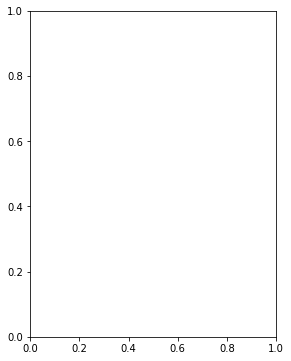

In [35]:
plt.rcParams["figure.figsize"] = (15,6)
# list all data in history
#summarize history for accuracy
plt.subplot(1,3,1)
plt.plot(history.history['score_accuracy'])
plt.plot(history.history['val_score_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplot(1,3,2)
# summarize history for loss
plt.plot(history.history['score_loss'])
plt.plot(history.history['val_score_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplot(1,3,3)
# summarize AUC for accuracy
plt.plot(history.history['score_auc_4'])
plt.plot(history.history['val_score_auc_4'])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def flatten(t):
    out = []
    ll = [item[0] for sublist in t for item in sublist]
    print(ll)
    for idx,v in enumerate(ll):
      if (idx) % 3 == 0:
        out.append(v)
    return out


In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = flatten(model.predict(testgen))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testgen.labels[:-3], y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Siamese Resnet (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

NameError: ignored

## Grad cam visualization

In [ ]:
# import the necessary packages
import cv2
class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  
  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = Model(
      inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output,
        self.model.output])

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = [tf.cast(image, tf.float32), tf.cast(image, tf.float32)]
      (convOutputs, (predictions,_,_)) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    init = tf.compat.v1.global_variables_initializer()
    sess = tf.compat.v1.Session()
    sess.run(init)
      
    cam = cam.eval(session=sess)
    
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    
    heatmap = cv2.resize(cam, (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5,
    colormap=cv2.COLORMAP_VIRIDIS):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)

In [ ]:
tf.config.run_functions_eagerly(True)
#Load model weights
model.load_weights(f"{CSV_FILE_PATH}model-attention.40-0.85.h5")

gcr = GradCAM(model,0, layerName = "res3d_branchmask12c")
gcl = GradCAM(model,0, layerName = "res3d_branchmask22c")


In [ ]:
def generate_maps(times=3):
  plt.rcParams["figure.figsize"] = (4,6)
  itr = traingen.__iter__()
  for i in range(1):
    X, y= next(itr)
    l = np.asarray(X[0][0][:])
    r = np.asarray(X[1][0][:])

    hmr = gcr.compute_heatmap(r[np.newaxis, :])
    hml = gcl.compute_heatmap(l[np.newaxis, :])

    origr = (r * 255).astype(np.uint8)
    origl = (l * 255).astype(np.uint8)

    heatmapr = cv2.resize(hmr, (origr.shape[1], origr.shape[0]))
    heatmapl = cv2.resize(hml, (origl.shape[1], origl.shape[0]))

    (rhm, outputr) = gcr.overlay_heatmap(heatmapr, origr, alpha=0.5)
    (lhm, outputl) = gcr.overlay_heatmap(heatmapl, origl, alpha=0.5)
    plt.figure()
    print(y)
    plt.subplot(1,2,1)
    outputr = np.vstack([origr, outputr,rhm])
    plt.imshow(outputr)
    plt.axis(False)

    plt.subplot(1,2,2)
    outputl = np.vstack([origl, outputl,lhm])
    plt.imshow(outputl)
    plt.axis(False)


([1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0])


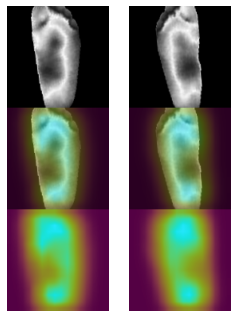

In [ ]:
generate_maps()

#### Do not run the below cell. It is for offline data augmentation


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from math import floor

def grayscale_to_rgb(image, channel_axis=-1):
  original = tf.constant(image)
  converted = tf.image.grayscale_to_rgb(original)
  return converted
def augment_images_offline(image_directory_l,image_directory_r, output_dir_l,output_dir_r, prefix):
  datagen = ImageDataGenerator(        
          rotation_range = 5,
          shear_range = 0.1,
          zoom_range = 0.1,
          horizontal_flip = False,
          vertical_flip=False,
          brightness_range = (0.5, 1.0))
  import numpy as np
  import os
  from PIL import Image
  l = image_directory_l
  r = image_directory_r
  dataset_L = []
  dataset_R = []
  l_images = os.listdir(l)
  r_images = os.listdir(r)
  for i, (l_img_n, r_img_n) in enumerate(zip(l_images,r_images)):    
      if (l_img_n.split('.')[1] == 'png' and r_img_n.split(".")[1] == "png"):        
          image_L = io.imread(image_directory_l +"/"+ l_img_n)
          image_R = io.imread(image_directory_r +"/"+ r_img_n)


          image_L = grayscale_to_rgb(np.expand_dims(image_L, axis=2))    
          image_R = grayscale_to_rgb(np.expand_dims(image_R, axis=2))     
          dataset_L.append(np.array(image_L.numpy().squeeze()))
          dataset_R.append(np.array(image_R.numpy().squeeze()))

  x_L = np.array(dataset_L)
  x_R = np.array(dataset_R)
  i = 0
  for batch in datagen.flow(x_L, batch_size=16,
                            shuffle=False,
                            save_to_dir=output_dir_l,
                            save_prefix=prefix,
                            save_format='png', seed=42):    
      i += 1    
      if i > 100:        
          break
  i=0
  for batch in datagen.flow(x_R, batch_size=16,
                            shuffle=False,
                            save_to_dir=output_dir_r,
                            save_prefix=prefix,
                            save_format='png', seed=42):    
      i += 1    
      if i > 100:        
          break

In [ ]:
augment_images_offline(IMG_PATH+"/DM_L/",IMG_PATH+"/DM_R/", IMG_PATH+"/Augmented/DM_L",IMG_PATH+"/Augmented/DM_R", prefix="DM")


In [ ]:
augment_images_offline(IMG_PATH+"/CG_L/",IMG_PATH+"/CG_R/", IMG_PATH+"/Augmented/CG_L",IMG_PATH+"/Augmented/CG_R", prefix="CG")
